In [32]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras
from keras.models import model_from_json
import numpy as np
import pandas as pd
import time
import tensorflow as tf

In [33]:
# datos: secuencia de observaciones como una lista o matriz 2D NumPy. Necesario.
# n_in: Número de observaciones de retraso como entrada (X). Los valores pueden estar entre [1..len (datos)] Opcional. El valor predeterminado es 1.
# n_out: Número de observaciones como salida (y). Los valores pueden estar entre [0..len (datos) -1]. Opcional. Por defecto es 1.
# dropnan: booleano si se deben soltar o no filas con valores NaN. Opcional. Por defecto es verdadero.


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
# observaciones pasadas  (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# tiempos futuros  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [34]:
data = pd.read_excel('../PreparacionDatos/FloraTotal_3mes_4V.xlsx' , sheet_name='FloraTotal' ,header=0)

In [35]:
data.columns

Index(['Unnamed: 0', 'PM10', 'Motos_vehiculos_particulares', 'Lluvia',
       'Poblacion'],
      dtype='object')

In [36]:
#Borro solo dejo PM10, lluvia, población y parque automovilístico

data = data.drop(['Unnamed: 0'], axis=1)


In [37]:
data.columns

Index(['PM10', 'Motos_vehiculos_particulares', 'Lluvia', 'Poblacion'], dtype='object')

In [38]:


data.describe()

,PM10,Motos_vehiculos_particulares,Lluvia,Poblacion
count,32.000000,32.000000,32.000000,3.200000e+01
mean,29.407487,498530.625000,0.282681,2.332282e+06
std,8.065527,96047.452489,0.186494,5.833838e+04
min,16.134058,348066.000000,0.015700,2.244668e+06
25%,24.819687,426908.500000,0.173525,2.288403e+06
50%,28.018413,505229.000000,0.244030,2.332209e+06
75%,33.663911,575963.250000,0.389344,2.376097e+06
max,47.904537,630478.000000,0.939613,2.420114e+06


In [39]:
data.columns

Index(['PM10', 'Motos_vehiculos_particulares', 'Lluvia', 'Poblacion'], dtype='object')

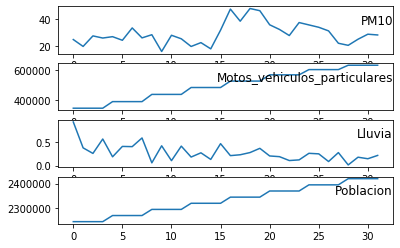

<Figure size 1728x432 with 0 Axes>

In [40]:
# Reprecentacion de los datos.
from matplotlib import pyplot
groups = [0,1,2,3]
i = 1
values = data.values
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.figure(figsize=(24,6))
pyplot.show()

In [41]:
data

,PM10,Motos_vehiculos_particulares,Lluvia,Poblacion
0,24.953753,348066,0.939613,2244668
1,19.868654,348066,0.382813,2244668
2,27.656900,348066,0.263172,2244668
3,26.076992,348066,0.572834,2244668
4,27.081070,391327,0.190382,2269653
5,24.417490,391327,0.413592,2269653
6,33.543011,391327,0.408934,2269653
7,26.189116,391327,0.595508,2269653
8,28.528126,438769,0.060729,2294653
9,16.134058,438769,0.426957,2294653


In [42]:
values = data.values
values = values.astype('float32')


In [43]:


#Normalize features(0,1)
#Este estimador escala y traduce cada característica
#individualmente de modo que esté en el rango dado en el conjunto de entrenamiento
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [44]:
scaled

array([[0.27760655, 0.        , 1.        , 0.        ],
       [0.11754924, 0.        , 0.3973462 , 0.        ],
       [0.3626902 , 0.        , 0.2678517 , 0.        ],
       [0.3129614 , 0.        , 0.6030158 , 0.        ],
       [0.3445655 , 0.15318406, 0.1890668 , 0.14240837],
       [0.2607273 , 0.15318406, 0.43065938, 0.14240837],
       [0.54796   , 0.15318406, 0.42561764, 0.14240837],
       [0.3164906 , 0.15318406, 0.627557  , 0.14240837],
       [0.3901127 , 0.3211727 , 0.04873698, 0.28490257],
       [0.        , 0.3211727 , 0.44512463, 0.28490257],
       [0.37726665, 0.3211727 , 0.09958397, 0.28490257],
       [0.29540235, 0.3211727 , 0.43738487, 0.28490257],
       [0.11658496, 0.4817537 , 0.18335706, 0.4275732 ],
       [0.2060349 , 0.4817537 , 0.2818562 , 0.4275732 ],
       [0.06128895, 0.4817537 , 0.12822917, 0.4275732 ],
       [0.49686676, 0.4817537 , 0.49481776, 0.4275732 ],
       [0.9867194 , 0.6312516 , 0.2164133 , 0.5703516 ],
       [0.70497006, 0.6312516 ,

In [45]:

reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.277607   0.000000   1.000000   0.000000  0.117549  0.000000  0.397346   
2   0.117549   0.000000   0.397346   0.000000  0.362690  0.000000  0.267852   
3   0.362690   0.000000   0.267852   0.000000  0.312961  0.000000  0.603016   
4   0.312961   0.000000   0.603016   0.000000  0.344566  0.153184  0.189067   
5   0.344566   0.153184   0.189067   0.142408  0.260727  0.153184  0.430659   

    var4(t)  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.142408  
5  0.142408  


In [46]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var1(t)',
       'var2(t)', 'var3(t)', 'var4(t)'],
      dtype='object')

In [47]:
#Dejo la variable objetico en PM10 (T) y y todas (T-1)...................
reframed.drop(reframed.columns[[0,5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.000000   1.000000   0.000000  0.117549
2   0.000000   0.397346   0.000000  0.362690
3   0.000000   0.267852   0.000000  0.312961
4   0.000000   0.603016   0.000000  0.344566
5   0.153184   0.189067   0.142408  0.260727


In [48]:
reframed.columns

Index(['var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var1(t)'], dtype='object')

In [49]:
values = reframed.values

In [51]:
values[:17, :]

array([[0.        , 1.        , 0.        , 0.11754924],
       [0.        , 0.3973462 , 0.        , 0.3626902 ],
       [0.        , 0.2678517 , 0.        , 0.3129614 ],
       [0.        , 0.6030158 , 0.        , 0.3445655 ],
       [0.15318406, 0.1890668 , 0.14240837, 0.2607273 ],
       [0.15318406, 0.43065938, 0.14240837, 0.54796   ],
       [0.15318406, 0.42561764, 0.14240837, 0.3164906 ],
       [0.15318406, 0.627557  , 0.14240837, 0.3901127 ],
       [0.3211727 , 0.04873698, 0.28490257, 0.        ],
       [0.3211727 , 0.44512463, 0.28490257, 0.37726665],
       [0.3211727 , 0.09958397, 0.28490257, 0.29540235],
       [0.3211727 , 0.43738487, 0.28490257, 0.11658496],
       [0.4817537 , 0.18335706, 0.4275732 , 0.2060349 ],
       [0.4817537 , 0.2818562 , 0.4275732 , 0.06128895],
       [0.4817537 , 0.12822917, 0.4275732 , 0.49686676],
       [0.4817537 , 0.49481776, 0.4275732 , 0.9867194 ],
       [0.6312516 , 0.2164133 , 0.5703516 , 0.70497006]], dtype=float32)

In [52]:
values = reframed.values

#Datos de entrenamiento y pruebas:
n_train_hours = 17
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [53]:
test

array([[0.6312516 , 0.23655559, 0.5703516 , 0.99999994],
       [0.6312516 , 0.28774852, 0.5703516 , 0.94905263],
       [0.6312516 , 0.3861732 , 0.5703516 , 0.6214743 ],
       [0.7764791 , 0.20872702, 0.7133417 , 0.5126626 ],
       [0.7764791 , 0.19244435, 0.7133417 , 0.37087148],
       [0.7764791 , 0.10211661, 0.7133417 , 0.6731488 ],
       [0.7764791 , 0.1174261 , 0.7133417 , 0.6181448 ],
       [0.89843214, 0.27022076, 0.85642815, 0.5631817 ],
       [0.89843214, 0.25771138, 0.85642815, 0.47911185],
       [0.89843214, 0.07924192, 0.85642815, 0.19131386],
       [0.89843214, 0.28694546, 0.85642815, 0.14310068],
       [1.0000001 , 0.        , 1.        , 0.28508067],
       [1.0000001 , 0.17980051, 1.        , 0.40200222],
       [1.0000001 , 0.14388649, 1.        , 0.38437665]], dtype=float32)

In [54]:
train

array([[0.        , 1.        , 0.        , 0.11754924],
       [0.        , 0.3973462 , 0.        , 0.3626902 ],
       [0.        , 0.2678517 , 0.        , 0.3129614 ],
       [0.        , 0.6030158 , 0.        , 0.3445655 ],
       [0.15318406, 0.1890668 , 0.14240837, 0.2607273 ],
       [0.15318406, 0.43065938, 0.14240837, 0.54796   ],
       [0.15318406, 0.42561764, 0.14240837, 0.3164906 ],
       [0.15318406, 0.627557  , 0.14240837, 0.3901127 ],
       [0.3211727 , 0.04873698, 0.28490257, 0.        ],
       [0.3211727 , 0.44512463, 0.28490257, 0.37726665],
       [0.3211727 , 0.09958397, 0.28490257, 0.29540235],
       [0.3211727 , 0.43738487, 0.28490257, 0.11658496],
       [0.4817537 , 0.18335706, 0.4275732 , 0.2060349 ],
       [0.4817537 , 0.2818562 , 0.4275732 , 0.06128895],
       [0.4817537 , 0.12822917, 0.4275732 , 0.49686676],
       [0.4817537 , 0.49481776, 0.4275732 , 0.9867194 ],
       [0.6312516 , 0.2164133 , 0.5703516 , 0.70497006]], dtype=float32)

In [55]:
train[:, :-1]

array([[0.        , 1.        , 0.        ],
       [0.        , 0.3973462 , 0.        ],
       [0.        , 0.2678517 , 0.        ],
       [0.        , 0.6030158 , 0.        ],
       [0.15318406, 0.1890668 , 0.14240837],
       [0.15318406, 0.43065938, 0.14240837],
       [0.15318406, 0.42561764, 0.14240837],
       [0.15318406, 0.627557  , 0.14240837],
       [0.3211727 , 0.04873698, 0.28490257],
       [0.3211727 , 0.44512463, 0.28490257],
       [0.3211727 , 0.09958397, 0.28490257],
       [0.3211727 , 0.43738487, 0.28490257],
       [0.4817537 , 0.18335706, 0.4275732 ],
       [0.4817537 , 0.2818562 , 0.4275732 ],
       [0.4817537 , 0.12822917, 0.4275732 ],
       [0.4817537 , 0.49481776, 0.4275732 ],
       [0.6312516 , 0.2164133 , 0.5703516 ]], dtype=float32)

In [56]:
train[:, -1]

array([0.11754924, 0.3626902 , 0.3129614 , 0.3445655 , 0.2607273 ,
       0.54796   , 0.3164906 , 0.3901127 , 0.        , 0.37726665,
       0.29540235, 0.11658496, 0.2060349 , 0.06128895, 0.49686676,
       0.9867194 , 0.70497006], dtype=float32)

In [61]:
train[:, 0:]

array([[0.        , 1.        , 0.        , 0.11754924],
       [0.        , 0.3973462 , 0.        , 0.3626902 ],
       [0.        , 0.2678517 , 0.        , 0.3129614 ],
       [0.        , 0.6030158 , 0.        , 0.3445655 ],
       [0.15318406, 0.1890668 , 0.14240837, 0.2607273 ],
       [0.15318406, 0.43065938, 0.14240837, 0.54796   ],
       [0.15318406, 0.42561764, 0.14240837, 0.3164906 ],
       [0.15318406, 0.627557  , 0.14240837, 0.3901127 ],
       [0.3211727 , 0.04873698, 0.28490257, 0.        ],
       [0.3211727 , 0.44512463, 0.28490257, 0.37726665],
       [0.3211727 , 0.09958397, 0.28490257, 0.29540235],
       [0.3211727 , 0.43738487, 0.28490257, 0.11658496],
       [0.4817537 , 0.18335706, 0.4275732 , 0.2060349 ],
       [0.4817537 , 0.2818562 , 0.4275732 , 0.06128895],
       [0.4817537 , 0.12822917, 0.4275732 , 0.49686676],
       [0.4817537 , 0.49481776, 0.4275732 , 0.9867194 ],
       [0.6312516 , 0.2164133 , 0.5703516 , 0.70497006]], dtype=float32)

In [62]:
# Datos de entrada y de salida.
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


#Remodelar la entrada para que sea 3D [muestras, pasos de tiempo, características]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17, 1, 3) (17,) (14, 1, 3) (14,)


In [63]:
#Diseñando la red neuronal.
model = Sequential()

#Capa de entrada (unidades, 1, 3)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

#Capa de salida.
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.name="LTSM_cali_3meses"

#fit(x=None, y=None, batch_size=None, epochs=1, 
#verbose=1, callbacks=None, validation_split=0.0, validation_data=None, 
#shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
#validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)

model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 17 samples, validate on 14 samples
Epoch 1/50





 - 1s - loss: 0.3461 - val_loss: 0.5064
Epoch 2/50
 - 0s - loss: 0.3406 - val_loss: 0.4980
Epoch 3/50
 - 0s - loss: 0.3353 - val_loss: 0.4896
Epoch 4/50
 - 0s - loss: 0.3300 - val_loss: 0.4812
Epoch 5/50
 - 0s - loss: 0.3247 - val_loss: 0.4728
Epoch 6/50
 - 0s - loss: 0.3195 - val_loss: 0.4644
Epoch 7/50
 - 0s - loss: 0.3142 - val_loss: 0.4560
Epoch 8/50
 - 0s - loss: 0.3089 - val_loss: 0.4476
Epoch 9/50
 - 0s - loss: 0.3036 - val_loss: 0.4392
Epoch 10/50
 - 0s - loss: 0.2984 - val_loss: 0.4308
Epoch 11/50
 - 0s - loss: 0.2937 - val_loss: 0.4224
Epoch 12/50
 - 0s - loss: 0.2892 - val_loss: 0.4142
Epoch 13/50
 - 0s - loss: 0.2848 - val_loss: 0.4060
Epoch 14/50
 - 0s - loss: 0.2803 - val_loss: 0.3978
Epoch 15/50
 - 0s - loss: 0.2759 - val_loss: 0.3896
Epoch 16/50
 - 0s - loss: 0.2715 - val_loss: 0.3817
Epoch 17/50
 - 0s - loss: 0.267

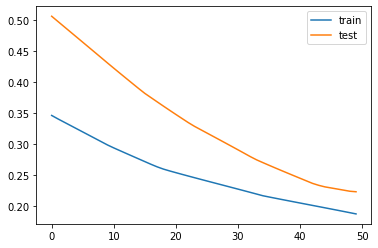

In [64]:

# Ajustado el modelo
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Seguimiento al modelo 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [65]:
test_X

array([[[0.6312516 , 0.23655559, 0.5703516 ]],

       [[0.6312516 , 0.28774852, 0.5703516 ]],

       [[0.6312516 , 0.3861732 , 0.5703516 ]],

       [[0.7764791 , 0.20872702, 0.7133417 ]],

       [[0.7764791 , 0.19244435, 0.7133417 ]],

       [[0.7764791 , 0.10211661, 0.7133417 ]],

       [[0.7764791 , 0.1174261 , 0.7133417 ]],

       [[0.89843214, 0.27022076, 0.85642815]],

       [[0.89843214, 0.25771138, 0.85642815]],

       [[0.89843214, 0.07924192, 0.85642815]],

       [[0.89843214, 0.28694546, 0.85642815]],

       [[1.0000001 , 0.        , 1.        ]],

       [[1.0000001 , 0.17980051, 1.        ]],

       [[1.0000001 , 0.14388649, 1.        ]]], dtype=float32)

In [66]:
yhat = model.predict(test_X)
yhat.shape

(14, 1)

In [67]:
# Datos de prediccion.
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X.shape

(14, 3)

In [68]:
# Datos de prediccion.
yhat

array([[0.34590578],
       [0.3542907 ],
       [0.37040386],
       [0.3802931 ],
       [0.3776036 ],
       [0.36267817],
       [0.3652083 ],
       [0.42755008],
       [0.42547545],
       [0.39582363],
       [0.43032286],
       [0.41789037],
       [0.44791692],
       [0.44192833]], dtype=float32)

In [69]:
#Datos de entrada
test_X[:,0:]

array([[0.6312516 , 0.23655559, 0.5703516 ],
       [0.6312516 , 0.28774852, 0.5703516 ],
       [0.6312516 , 0.3861732 , 0.5703516 ],
       [0.7764791 , 0.20872702, 0.7133417 ],
       [0.7764791 , 0.19244435, 0.7133417 ],
       [0.7764791 , 0.10211661, 0.7133417 ],
       [0.7764791 , 0.1174261 , 0.7133417 ],
       [0.89843214, 0.27022076, 0.85642815],
       [0.89843214, 0.25771138, 0.85642815],
       [0.89843214, 0.07924192, 0.85642815],
       [0.89843214, 0.28694546, 0.85642815],
       [1.0000001 , 0.        , 1.        ],
       [1.0000001 , 0.17980051, 1.        ],
       [1.0000001 , 0.14388649, 1.        ]], dtype=float32)

In [70]:
# Datos de prediccion +  Datos de prediccion.
concatenate((yhat, test_X[:, :]), axis=1)

array([[0.34590578, 0.6312516 , 0.23655559, 0.5703516 ],
       [0.3542907 , 0.6312516 , 0.28774852, 0.5703516 ],
       [0.37040386, 0.6312516 , 0.3861732 , 0.5703516 ],
       [0.3802931 , 0.7764791 , 0.20872702, 0.7133417 ],
       [0.3776036 , 0.7764791 , 0.19244435, 0.7133417 ],
       [0.36267817, 0.7764791 , 0.10211661, 0.7133417 ],
       [0.3652083 , 0.7764791 , 0.1174261 , 0.7133417 ],
       [0.42755008, 0.89843214, 0.27022076, 0.85642815],
       [0.42547545, 0.89843214, 0.25771138, 0.85642815],
       [0.39582363, 0.89843214, 0.07924192, 0.85642815],
       [0.43032286, 0.89843214, 0.28694546, 0.85642815],
       [0.41789037, 1.0000001 , 0.        , 1.        ],
       [0.44791692, 1.0000001 , 0.17980051, 1.        ],
       [0.44192833, 1.0000001 , 0.14388649, 1.        ]], dtype=float32)

In [71]:
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat

array([[2.7123652e+01, 5.2633900e+05, 2.3425704e-01, 2.3447340e+06],
       [2.7390043e+01, 5.2633900e+05, 2.8155482e-01, 2.3447340e+06],
       [2.7901966e+01, 5.2633900e+05, 3.7249056e-01, 2.3447340e+06],
       [2.8216152e+01, 5.6735300e+05, 2.0854589e-01, 2.3698210e+06],
       [2.8130705e+01, 5.6735300e+05, 1.9350214e-01, 2.3698210e+06],
       [2.7656517e+01, 5.6735300e+05, 1.1004725e-01, 2.3698210e+06],
       [2.7736902e+01, 5.6735300e+05, 1.2419187e-01, 2.3698210e+06],
       [2.9717529e+01, 6.0179400e+05, 2.6536071e-01, 2.3949250e+06],
       [2.9651617e+01, 6.0179400e+05, 2.5380316e-01, 2.3949250e+06],
       [2.8709566e+01, 6.0179400e+05, 8.8913046e-02, 2.3949250e+06],
       [2.9805620e+01, 6.0179400e+05, 2.8081286e-01, 2.3949250e+06],
       [2.9410637e+01, 6.3047800e+05, 1.5700484e-02, 2.4201140e+06],
       [3.0364594e+01, 6.3047800e+05, 1.8182035e-01, 2.4201140e+06],
       [3.0174334e+01, 6.3047800e+05, 1.4863895e-01, 2.4201140e+06]],
      dtype=float32)

In [72]:
inv_yhat = inv_yhat[:,0]

In [73]:
inv_yhat

array([27.123652, 27.390043, 27.901966, 28.216152, 28.130705, 27.656517,
       27.736902, 29.71753 , 29.651617, 28.709566, 29.80562 , 29.410637,
       30.364594, 30.174334], dtype=float32)

In [74]:
# invierco el scalar de la prediccion
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


In [75]:
inv_yhat

array([27.123652, 27.390043, 27.901966, 28.216152, 28.130705, 27.656517,
       27.736902, 29.71753 , 29.651617, 28.709566, 29.80562 , 29.410637,
       30.364594, 30.174334], dtype=float32)

In [76]:

#Invierco el scalar de los dato reales
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calcular RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9.267


In [77]:
#Datos reales
inv_y

array([47.904537, 46.285915, 35.878597, 32.421597, 27.916824, 37.52032 ,
       35.772816, 34.02661 , 31.35567 , 22.212193, 20.680435, 25.191208,
       28.90586 , 28.345888], dtype=float32)

In [78]:
#Datos prediccion
inv_yhat

array([27.123652, 27.390043, 27.901966, 28.216152, 28.130705, 27.656517,
       27.736902, 29.71753 , 29.651617, 28.709566, 29.80562 , 29.410637,
       30.364594, 30.174334], dtype=float32)

In [79]:
# Vuelvo el modelo un archivo .json
model_json = model.to_json()
with open("../Modelamiento/model.json", "w") as json_file:
    json_file.write(model_json)
    

# Guardar el Modelo
model.save_weights('../Modelamiento/LTSM_Cali_3meses.h5')

In [73]:
model

In [74]:
train.shape

(23, 4)

In [97]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________
